# Computational Thermofluid Dynamics - Chapter 2

Technical University of Munich, Professur für Thermofluiddynamik - Pr. Polifke

Created: 04/2024 | J. Yao, N. Garcia, G. Varillon

==============================================================================================

# Finite Differences
The 2D steady heat equation reads:
$$
\frac{\partial}{\partial x}(\lambda\frac{\partial T}{\partial x}) + \frac{\partial}{\partial y}(\lambda\frac{\partial T}{\partial y}) = 0
$$

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
class SteadyHeat2D:
    def __init__(self, Lx, Ly, dimX, dimY):
        self.l = Lx
        self.h = Ly
        self.dimX = dimX
        self.dimY = dimY

        # Add features for a source

        # Initialize these values
        self.dx = Lx/self.dimX
        self.dy = Ly/self.dimY

        # initialize A and b as empty matrices to then fill them later on using the given formulation
        self.A = np.zeros([self.dimX*self.dimY, self.dimX*self.dimY])
        self.set_inner()
        self.b = np.zeros([self.dimX*self.dimY])
        

    # build the linear system
    def set_inner(self):
        inv_dx = 1.0 / (self.dx * self.dx)
        inv_dy = 1.0 / (self.dy * self.dy)
        
        for i in range(self.dimX+1, (self.dimX*self.dimY)-self.dimX-1, self.dimX):
            for j in range(self.dimX-2):
                k = i+j
                self.A[k][k - self.dimX] = inv_dy
                self.A[k][k-1] = inv_dx
                self.A[k][k] = -2.0 * (inv_dx + inv_dy)
                self.A[k][k + self.dimX] = inv_dy
                self.A[k][k+1] = inv_dx

    # set the boundary conditions
    # west: Derichlet
    def set_west(self, bc_type, T_d = 0.0, q = 0.0, alpha = 0.0, T_inf = 0.0):
        index = range(0, self.dimX*self.dimY, self.dimX) 
        for i in index:
            self.A[i][i] = 1.0
        
        self.b[index] = T_d
        

    # north and east: Robin
    def set_n_e(self, bc_type, T_d = 0.0, q = 0.0, alpha = 0.0, T_inf = 0.0):
        index = range(1, self.dimX, 1) 
        for i in index:
            self.A[i][i] = alpha + 3/(2*self.dy)
            self.A[i][i + self.dimX] = - 2/self.dy
            self.A[i][i + 2*self.dimX] = 1/(2*self.dy)
        
        self.b[index] = alpha*T_inf

        index1 = range(2*self.dimX-1, self.dimX*self.dimY - self.dimX, self.dimX)
        for i in index1:
            self.A[i][i] = alpha + 3.0/(2*self.dx)
            self.A[i][i-1] = - 2.0/self.dx
            self.A[i][i-2] = 1/(2.0*self.dx)

        self.b[index1] = alpha*T_inf
        

    def set_south(self, bc_type, T_d = 0.0, q = 0.0, alpha = 0.0, T_inf = 0.0):
        index = range((self.dimX*self.dimY)-self.dimX+1, self.dimX*self.dimY,1)
        for i in index:
            self.A[i][i] = 3/(2*self.dy)
            self.A[i][i - self.dimX] = -2/self.dy
            self.A[i][i - 2*self.dimX] = 1/(2*self.dy)

        self.b[index] = q
    
    # # # solve the linear system
    def solve(self, A, b):
        T = np.linalg.solve(A, b)
        T_matrix = T.reshape(self.dimX, self.dimY)
        T_matrix = pd.DataFrame(T_matrix)
        # print(T_matrix)
        plt.imshow(T_matrix, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Temperature')
        plt.title('Temperature Distribution')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

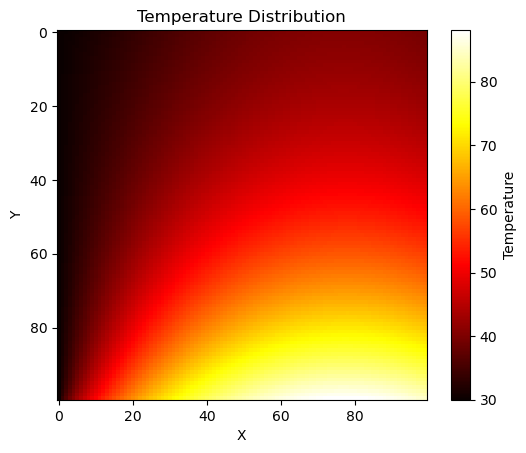

In [26]:
# Test
Lx = 1
Ly = 1
dimX = 100
dimY = 100
bc_type_west = "Direchlet"
bc_type_n_e = "Robin"
bc_type_south = "Neumann"

heat = SteadyHeat2D(Lx, Ly, dimX, dimY)
heat.set_west(bc_type_west, T_d = 30.0)
heat.set_n_e(bc_type_n_e, alpha = 0.5, T_inf = 17.0)
heat.set_south(bc_type_south, q = 100)


c = pd.DataFrame(heat.A)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 100)  # Prevent line wrapping
# print(c)

print(" ")
b = pd.DataFrame(heat.b)
# print(b)

T = heat.solve(heat.A,heat.b)